In [9]:
# Install Kaggle
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
# Mount ke Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [11]:
# Setup folder
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [12]:
# Download Dataset
!kaggle datasets download -d jaganadhg/house-hold-energy-data

  0% 0.00/2.58M [00:00<?, ?B/s]
100% 2.58M/2.58M [00:00<00:00, 122MB/s]


In [13]:
# Unzip dataset
!unzip \*.zip && rm *.zipa

Archive:  house-hold-energy-data.zip
replace D202.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: D202.csv                
replace D202.xlsx? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: D202.xlsx               


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [15]:
# get dataset
df = pd.read_csv("D202.csv")

In [16]:
# Remove unused columns
df = df.drop(columns=["NOTES", "START TIME", "END TIME", "UNITS", "COST", "TYPE"])

In [17]:
# Convert string to date time format
df['DATE'] = pd.to_datetime(df['DATE'])

In [18]:
df.tail(10)

,DATE,USAGE
70358,2018-10-24,0.03
70359,2018-10-24,0.03
70360,2018-10-24,0.02
70361,2018-10-24,0.02
70362,2018-10-24,0.02
70363,2018-10-24,0.02
70364,2018-10-24,0.03
70365,2018-10-24,0.03
70366,2018-10-24,0.03
70367,2018-10-24,0.03


In [19]:
# check types
df.dtypes

DATE     datetime64[ns]
USAGE           float64
dtype: object

In [20]:
# check null
df.isnull().sum()

DATE     0
USAGE    0
dtype: int64

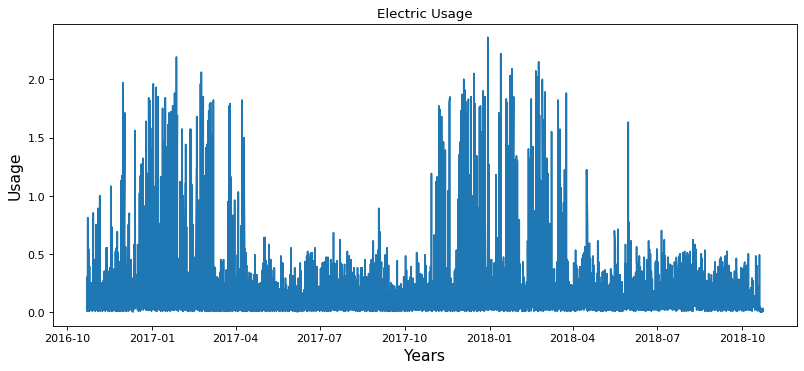

In [21]:
# Visualize data
figure(figsize=(12, 5), dpi=80, linewidth=10)
plt.plot(df['DATE'].values, df['USAGE'].values)
plt.title('Electric Usage')
plt.xlabel('Years', fontsize=14)
plt.ylabel('Usage', fontsize=14)
plt.show()

In [22]:
from sklearn.preprocessing import MinMaxScaler
mx = MinMaxScaler()

In [23]:
# Normalization
df['USAGE'] = mx.fit_transform(df[['USAGE']])

In [24]:
date = df['DATE'].values
usage = df['USAGE'].values

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
x_train, x_test, y_train, y_test = train_test_split(usage, date, train_size=0.8, test_size=0.2, shuffle=False)

In [27]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [28]:
import tensorflow as tf

In [29]:
# Get threshold MAE
threshold_mae = (df['USAGE'].max() - df['USAGE'].min()) * 10/100

In [30]:
print(threshold_mae)

0.1


In [41]:
train_set = windowed_dataset(x_train, window_size=64, batch_size=1024, shuffle_buffer=1000)
val_set = windowed_dataset(x_test, window_size=64, batch_size=1024, shuffle_buffer=1000)
model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(60, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(60)),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(1),
])

In [42]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [43]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae') < 0.1 and logs.get('val_mae')< 0.1 ):
      print("\nMAE dari model < 10% skala data")
      self.model.stop_training = True
callbacks = myCallback()

In [44]:
history = model.fit(train_set, validation_data = val_set, epochs=100, callbacks=[callbacks])

Epoch 1/100
     55/Unknown - 140s 2s/step - loss: 0.0061 - mae: 0.0521
MAE dari model < 10% skala data
55/55 [==============================] - 162s 3s/step - loss: 0.0061 - mae: 0.0521 - val_loss: 0.0015 - val_mae: 0.0349
